In [1]:
import torch as th
import optuna

from environments.environment_tsp import EnviornmentTSP
from networks.basic_network import BasicNetwork
from networks.more_basic_net import MoreBasicNetwork
from params import default_params, set_tsp_params
from experiments.actor_critic_experiment import ActorCriticExperiment

# ------------------------- CONTROLLERS ----------------------------
from controllers.ac_controller import ActorCriticController
from controllers.epsilon_greedy_controller import EpsilonGreedyController
# ------------------------------------------------------------------

# ------------------------- LEARNERS --------------------------------
from learners.reinforce_learner import ReinforceLearner
from learners.biased_reinforce_learner import BiasedReinforceLearner
from learners.actor_critic_learner import ActorCriticLearner
from learners.off_policy_actor_critic_learner import OffpolicyActorCriticLearner
from learners.ppo_learner import PPOLearner
# ------------------------------------------------------------------

from generators.tsp_generator import TSPGenerator
from exact_solvers.solver_tsp import solve_tsp

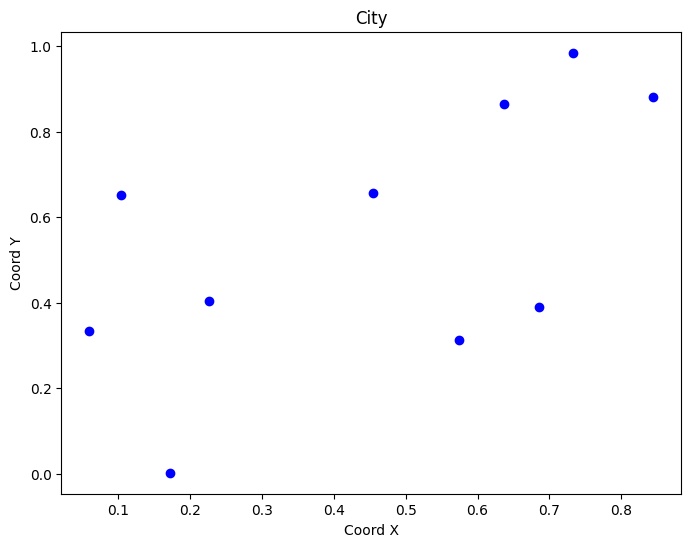

In [2]:
max_nodes_per_graph = 10
instance = 0
cities = th.load(f"training/tsp/size_{max_nodes_per_graph}/instance_{instance}.pt") 
tsp_generator = TSPGenerator()
tsp_generator.plot_instance(cities)

In [3]:
permutation, distance = solve_tsp(cities)
print(f"Permutation: {permutation}\nDistance: {distance}")

Permutation: [0, 5, 3, 8, 7, 4, 6, 9, 1, 2]
Distance: 2.9008774757385254


In [5]:
# Get params
params = default_params()

rollouts_per_batch = 50
pct_epsilon_anneal_time = 0.75
max_episodes = 750

params['problem'] = 'tsp'
params['node_dimension'] = 2
params['max_nodes_per_graph'] = max_nodes_per_graph
params['max_episode_length'] = max_nodes_per_graph + 1
params['max_episodes'] = max_episodes
params['batch_size'] = params['max_episode_length'] * rollouts_per_batch
params['max_steps'] = params['max_episodes'] * params['max_episode_length'] * rollouts_per_batch
params['epsilon_start'] = 0.9
params['epsilon_finish'] = 1E-5
params['epsilon_anneal_time'] =  pct_epsilon_anneal_time * params['max_steps']
params['lr'] = 5E-4
params['gamma'] = 0.99
params['entropy_regularization'] = True
params['entropy_weight'] = 0.1
params['plot_frequency'] = 10
print("Epsilon anneal time: ", params['epsilon_anneal_time'])
print("Device in use: ", params['device'])

Epsilon anneal time:  309375.0
Device in use:  cpu


/home/tomas/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, ReinforceLearner(model, params))
experiment.run()

In [ ]:
experiment.plot_rollout()

In [ ]:
params['advantage_bias'] = True
params['value_targets'] = 'td'

In [ ]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, BiasedReinforceLearner(model, params))
experiment.run()

In [ ]:
experiment.plot_rollout()

In [ ]:
params['advantage_bootstrap'] = True

In [ ]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, ActorCriticLearner(model, params))
experiment.run()

In [ ]:
experiment.plot_rollout()

In [ ]:
params['offpolicy_iterations'] = 50

In [ ]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, OffpolicyActorCriticLearner(model, params))
experiment.run()

In [ ]:
experiment.plot_rollout()

In [ ]:
params['ppo_clipping'] = True
params['ppo_clip_eps'] = 0.1

In [ ]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, PPOLearner(model, params))
experiment.run()

In [ ]:
experiment.plot_rollout()

In [ ]:
def objective(trial):
    # Define the hyperparameters as trial suggestions
    lr = trial.suggest_float('lr', 1e-6, 1e-1, log=True)
    pct_epsilon_anneal_time = trial.suggest_float('pct_epsilon_anneal_time', 0.3, 0.8)
    epsilon_start = trial.suggest_float('epsilon_start', 0.5, 1)
    epsilon_finish = trial.suggest_float('epsilon_finish', 0.00001, 0.5)

    # Use these parameters to create components
    params['epsilon_start'] = epsilon_start
    params['epsilon_finish'] = epsilon_finish
    params['epsilon_anneal_time'] = pct_epsilon_anneal_time * params['max_steps']
    params['lr'] = lr
    params['plot_frequency'] = None


    model = MoreBasicNetwork(params)
    env = EnviornmentTSP(cities, params)
    experiment = ActorCriticExperiment(params, model, env, ReinforceLearner(model, params))

    # Perform training and return the evaluation metric
    final_metric = experiment.run()  # Assume `run` returns a performance indicator
    return final_metric

study = optuna.create_study(direction='maximize')  # or 'minimize' if you're minimizing a metric
study.optimize(objective, n_trials=25)  # You can adjust the number of trials